In [5]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


## logistic

logistic是一种处理2分类的线性模型，其中，$x \in R^D, y \in {0, 1}$，我们希望找到一个非线性函数$g()$，使得$R^D --> {0, 1}$，以此来预测后验概率$P(Y=1|X)$
- 模型：$P(y=1|X) = \frac{1}{1+e^{-w^Tx}}$，$P(y=0|X) = \frac{e^{-w^Tx}}{1+e^{-w^Tx}}$
- 损失函数：$L = -\frac{1}{N} \sum_{n=1}^N y^{(n)} log(\hat y^{(n)}) + (1 - y^{(n)}) log(1 - \hat y^{(n)})$
- 梯度：
    - $\frac{\partial L}{\partial w} = \frac{1}{N} \sum_{n=1}^Nx^{n} (\hat y^{(n)} - y^{(n)})$
    - $\frac{\partial L}{\partial b} = \frac{1}{N} \sum_{n=1}^N (\hat y^{(n)} - y^{(n)})$

以下使用sklearn的鸢尾花数据集来实现logistic

### numpy版

In [6]:
import sys
sys.path.append("../d2l_func/")
import numpy as np
import pandas as pd
from data_prepare import data_iter
from sqdm import sqdm
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [7]:
def bootstrap(x, y):
    """自助法实现"""
    data_num = len(y)
    
    # 训练集的index和测试集的index
    batch_index = np.random.choice(data_num, size=data_num, replace=True)
    out_index = np.array(list(set(range(data_num)).difference(set(batch_index))))
    
    # 训练集
    xtrain, ytrain = x[batch_index], y[batch_index]
    # 测试集
    xtest, ytest = x[out_index], y[out_index]
    
    return xtrain, ytrain, xtest, ytest

In [8]:
# 处理数据集
iris = load_iris()
iris_data = np.hstack((iris.data, np.expand_dims(iris.target, 1)))
iris_data = iris_data[iris.target < 2]
xtrain, ytrain, xtest, ytest = bootstrap(iris_data[:, :4], iris_data[:, 4])

In [9]:
class LogisticModel(object):
    def __init__(self, alpha=0.01, weight_decay=0):
        self.w = None
        self.b = 0
        self.alpha = alpha
        self.weight_decay = weight_decay
        self.count = 0
        
    def linreg(self, X):
        return X@self.w + self.b
    
    def sigmoid(self, y):
        return 1 / (1 + np.exp(-y))
    
    def entropy_loss(self, y_pred, y):
        y_pred = np.where(y==0, 1-y_pred, y_pred)
        loss = -(np.log(y_pred).sum())/len(y)
        return loss
        
    def fit(self, X, y):
        fea_num = int(X.size / len(y))
        if self.count == 0:
            self.w = np.zeros(fea_num)
        
        # reshape X and y
        X = X.reshape(len(y), fea_num)
        y = y.reshape(-1)
        
        # predict
        y_pred = self.predict_prob(X)
        
        # update grad
        dw = (X.T@(y_pred - y)).sum()/len(y) + self.weight_decay*self.w
        db = (y_pred - y).sum()/len(y) + self.weight_decay*self.b
        self.w -= self.alpha * dw
        self.b -= self.alpha * db
        self.count += 1
    
    def predict_prob(self, X):
        y_pred = self.sigmoid(self.linreg(X)).reshape(-1)
        return y_pred
    
    def predict(self, X):
        y_pred = self.predict_prob(X)
        y_pred = np.where(y_pred>0.5, 1, 0)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        acc = (y_pred == y).sum()/len(y)
        return acc

In [10]:
params={
    "model": LogisticModel(alpha=0.02, weight_decay=0),
    "epoch_num": 100,
    "batch_size": 1,
}

process_bar = sqdm()
def train(model, epoch_num, batch_size):
    for epoch in range(epoch_num):
        print(f"Epoch [{epoch+1}/{epoch_num}]")
        for xdata, ydata in data_iter(batch_size, xtrain, ytrain):
            model.fit(xdata, ydata)
            
            # train
            train_pred = model.predict_prob(xdata)
            train_loss = round(model.entropy_loss(train_pred, ydata.reshape(train_pred.shape)), 5)
            train_acc = model.score(xdata, ydata)
            
            # test
            test_pred = model.predict_prob(xtest)
            test_loss = round(model.entropy_loss(test_pred, ytest.reshape(test_pred.shape)), 5)
            test_acc = model.score(xtest, ytest)

            process_bar.show_process(len(ytrain), batch_size, train_loss=train_loss, 
                                    test_loss=test_loss, train_score=train_acc, test_score=test_acc)
            
        print("\n")
    return model
    
model = train(**params)

Epoch [1/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1164, train_score: 1.000, test_loss: 1.0133, test_score: 0.514

Epoch [2/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1200, train_score: 1.000, test_loss: 0.9936, test_score: 0.514

Epoch [3/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1235, train_score: 1.000, test_loss: 0.9746, test_score: 0.514

Epoch [4/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1270, train_score: 1.000, test_loss: 0.9562, test_score: 0.514

Epoch [5/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1305, train_score: 1.000, test_loss: 0.9385, test_score: 0.514

Epoch [6/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1338, train_score: 1.000, test_loss: 0.9214, test_score: 0.514

Epoch [7/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1372, train_score: 1.000, test_loss: 0.9049, test_score: 0.514

Epoch [8/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 

100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2179, train_score: 1.000, test_loss: 0.5211, test_score: 0.686

Epoch [62/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2185, train_score: 1.000, test_loss: 0.5182, test_score: 0.686

Epoch [63/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2191, train_score: 1.000, test_loss: 0.5154, test_score: 0.686

Epoch [64/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2197, train_score: 1.000, test_loss: 0.5126, test_score: 0.686

Epoch [65/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2202, train_score: 1.000, test_loss: 0.5098, test_score: 0.686

Epoch [66/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2208, train_score: 1.000, test_loss: 0.5071, test_score: 0.686

Epoch [67/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2213, train_score: 1.000, test_loss: 0.5045, test_score: 0.686

Epoch [68/100]
100/100 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train

In [11]:
# 测试集结果
model.predict(iris_data[:, :4])
model.score(iris_data[:, :4], iris_data[:, 4])

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

0.74

## softmax

softmax可以看成是一个多项的logistic，实际上softmax是一种条件最大熵模型
- 对于某个样本属于第c类的概率为：
    - $P(y=c|x) = \frac{exp(w^T_cx)}{\sum_{c'=1}^{C}exp(w^T_{c'}x)}$
    - 决策函数为
        - $\hat y = \underset{c}{arg min} \  P(y=c|x) = \underset{c}{arg min}\  w^T_cx$
- 损失函数：$L = - \frac{1}{N} \sum_{n=1}^N \sum_{c=1}^{C} y_c^{(n)}log(\hat y_c^{(n)})= - \sum_{n=1}^N  (y^{(n)})^Tlog(\hat y^{(n)})$
- 梯度：
    - $\frac{\partial L}{\partial w} = \frac{1}{N} \sum_{n=1}^N x^{(n)}(\hat y^{(n)} - y^{(n)})^T$
    - $\frac{\partial L}{\partial b} = \frac{1}{N} \sum_{n=1}^N (\hat y^{(n)} - y^{(n)})^T$

### numpy版

还是先以鸢尾花的例子来实现

In [12]:
# 处理数据集
iris = load_iris()
iris_data = np.hstack((iris.data, np.expand_dims(iris.target, 1)))
xtrain, ytrain, xtest, ytest = bootstrap(iris_data[:, :4], iris_data[:, 4])

# 处理标签--> (0 --> [1, 0, 0])
label_dict = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1]
}

data = np.array(list(map(lambda x: label_dict[x], iris_data[:, 4])))
ytrain = np.array(list(map(lambda x: label_dict[x], list(ytrain))))
ytest = np.array(list(map(lambda x: label_dict[x], list(ytest))))

In [13]:
class SoftmaxModel(object):
    """实现softmax"""
    def __init__(self, fea_num, cate_num, alpha=0.01, weight_decay=0):
        self.w = np.zeros([fea_num, cate_num])
        self.b = np.zeros(cate_num)
        self.fea_num = fea_num
        self.cate_num = cate_num
        self.alpha = alpha
        self.weight_decay = weight_decay
        self.count = 0
        
    def linreg(self, X):
        return X@self.w + self.b
    
    def softmax(self, y):
        return np.exp(y)/np.expand_dims(np.exp(y).sum(axis = 1), 1)
    
    def entropy_loss(self, y_pred, y):
        loss = -(y*np.log(y_pred)).sum()/len(y)
        return loss
    
    def cal_grad(self, X, y_diff):
        result = np.zeros([self.fea_num, self.cate_num])
        for i in range(len(X)):
            result += np.outer(X.T[:, i], y_diff[i, :])
        return result / len(X)
        
        
    def fit(self, X, y):
        # predict
        y_pred = self.predict_prob(X)
        
        # update_grad
        dw = self.cal_grad(X, (y_pred-y)) + self.weight_decay * self.w
        db = (y_pred-y).sum(axis=0)/len(y) + self.weight_decay * self.b
        self.w -= self.alpha * dw
        self.b -= self.alpha * db
        self.count += 1
        
            
    def predict_prob(self, X):
        y_pred = self.softmax(self.linreg(X))
        return y_pred
    
    def predict(self, X):
        y_pred = self.predict_prob(X)
        pred_index = np.argmax(y_pred, axis=1)
        return pred_index
    
    def score(self, X, y):
        y_pred = self.predict_prob(X)
        pred_index = np.argmax(y_pred, axis=1)
        label_index = np.argmax(y, axis = 1)
        acc = (pred_index == label_index).sum()/len(y)
        return acc

In [14]:
params={
    "model": SoftmaxModel(fea_num=4, cate_num=3, alpha=0.01, weight_decay=0),
    "epoch_num": 100,
    "batch_size": 1,
}

process_bar = sqdm()
def train(model, epoch_num, batch_size):
    for epoch in range(epoch_num):
        print(f"Epoch [{epoch+1}/{epoch_num}]")
        for xdata, ydata in data_iter(batch_size, xtrain, ytrain):
            model.fit(xdata, ydata)
            
            # train
            train_pred = model.predict_prob(xdata)
            train_loss = model.entropy_loss(train_pred, ydata.reshape(train_pred.shape))
            train_acc = model.score(xdata, ydata)
            
            # test
            test_pred = model.predict_prob(xtest)
            test_loss = model.entropy_loss(test_pred, ytest.reshape(test_pred.shape))
            test_acc = model.score(xtest, ytest)

            process_bar.show_process(len(ytrain), batch_size, train_loss=train_loss, 
                                    test_loss=test_loss, train_score=train_acc, test_score=test_acc)
            
        print("\n")
    return model
    
model = train(**params)

Epoch [1/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2473, train_score: 1.000, test_loss: 0.6957, test_score: 0.655

Epoch [2/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2280, train_score: 1.000, test_loss: 0.5803, test_score: 0.655

Epoch [3/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2223, train_score: 1.000, test_loss: 0.5214, test_score: 0.655

Epoch [4/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2206, train_score: 1.000, test_loss: 0.4806, test_score: 0.655

Epoch [5/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2205, train_score: 1.000, test_loss: 0.4487, test_score: 0.673

Epoch [6/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2211, train_score: 1.000, test_loss: 0.4220, test_score: 0.727

Epoch [7/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2221, train_score: 1.000, test_loss: 0.3991, test_score: 0.782

Epoch [8/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 

150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2527, train_score: 1.000, test_loss: 0.1383, test_score: 0.982

Epoch [62/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2527, train_score: 1.000, test_loss: 0.1373, test_score: 0.982

Epoch [63/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2528, train_score: 1.000, test_loss: 0.1363, test_score: 0.982

Epoch [64/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2528, train_score: 1.000, test_loss: 0.1353, test_score: 0.982

Epoch [65/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2528, train_score: 1.000, test_loss: 0.1344, test_score: 0.982

Epoch [66/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2528, train_score: 1.000, test_loss: 0.1335, test_score: 0.982

Epoch [67/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2528, train_score: 1.000, test_loss: 0.1326, test_score: 0.982

Epoch [68/100]
150/150 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train

In [15]:
# 测试集结果
model.predict(iris_data[:, :4])
model.score(iris_data[:, :4], data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

0.9733333333333334

### pytorch

#### Fashion mnist

一个多分类的图像分类数据集，比mnist更加复杂

使用torchvision包来处理，主要用来构建计算机视觉模型
- torchvision.datasets: 一些加载数据的函数及常用的数据集接口（是torch.utils.data的子类）
- torchvision.models：包含常用的模型结构（含有预训练模型），像AlexNet，VGG，ResNet
- torchvision.transfroms：常用的图片变换，例如剪裁、旋转等
- torchvision.utils：其他一些有用的方法

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../d2l_func/")
from draw import *

使用torchvision.datasets下载数据集，通过参数`train`或者`test`来指定获取训练集还是测试集
- 可以指定`transform.ToTensor()`将所有数据转换为`Tensor`，如果不转换就会返回`PIL`图片
- `transforms.ToTensor`还会将尺寸为`H x W x C`且数据位于(0, 255)的PIL图片或者数据类型为`uint8`的numpy数组转化为尺寸为`C x H x W`且数据类型为torch.float32且位于[0., 1.]的Tensor
    - numpy和pytorch，对于3维的张量，都是维度0代表通道，维度1代表高度，维度2代表宽度
- 如果用0-255整数来表示图片数据，一律将其转为uint8，避免不必要的bug

In [13]:
# 不需要提前创建目录，root会自动创建
# train用于确认的是训练集还是测试集
# tranforms.ToTensor()转化为torch.float32，且归一化[0., 1.]范围内的tensor
mnist_train = torchvision.datasets.FashionMNIST(root="../data/", train=True, 
                                                download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root="../data/", train=False,
                                              download=True, transform=transforms.ToTensor())

实际上`minst_train`还有`minst_test`都是torch.utils.data.Dataset的子类，所以可以用`len`来获取数据集的大小

In [14]:
type(mnist_train)
len(mnist_train)
len(mnist_test)

<class 'torchvision.datasets.mnist.FashionMNIST'>

60000

10000

In [15]:
feature, label = mnist_train[0]
feature.shape
type(feature)
# 已经转为torch.float32位的浮点数，也转成了C x H x W的形状
# feature
label

torch.Size([1, 28, 28])

<class 'torch.Tensor'>

9

In [17]:
# # 不采用transforms.ToTensor时，显示的是一张PIL图片
# mnist_test = torchvision.datasets.FashionMNIST(root="../data/", train=False,
#                                               download=True)
# feature, label = mnist_test[0]
# feature
# label

9

#### 打印对应的图片

In [18]:
# fashion_mnist数据集对应10个类别
def get_fashion_mnist_label(labels):
    text_labels = ["t-shirt", "trouse", "pullover", "dress", "coat", "sandal", 
                   "shirt", "sneaker", "bag", "ankle boot"]
    return [text_labels[int(i)] for i in labels]

In [19]:
# 在一行里面画出多张图像和对应标签的函数
def show_fashion_mnist(image, labels):
    # 使用自定义来设置图片格式
    set_fig_display()
    
    _, axes= plt.subplots(1, len(labels), figsize=(12, 12))
    for ax, img, label in zip(axes, image, labels):
        # 画图时需要将图片转为2维的图片
        ax.imshow(img.view(28, 28))
        ax.set_title(label)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

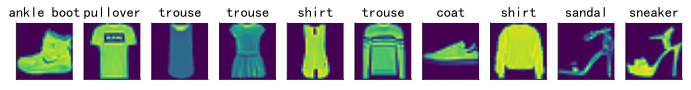

In [20]:
x, y = [], []
for i in range(10):
    x.append(mnist_train[i][0])
    y.append(mnist_test[i][1])

show_fashion_mnist(x, get_fashion_mnist_label(y))

#### 读取小批量

因为`mnist_train`是`torch.utils.data.Dataset`的子类，所以可以将其传入`torch.utils.data.DataLoader`来创建一个读取小批量数据样本的DataLoader实例

数据读取制约了训练的性能，Pytorch的DataLoader中一个方便的功能是允许使用多进程来加速数据读取
- 使用`num_workers`来设置4个进程读取数据

In [21]:
import sys
import torch.utils.data as Data

batch_size = 256
if sys.platform.startswith("win"):
    # window下不是直接显示'window'，有的显示'win32'
    num_workers = 0
else:
    num_workers = 4
    
train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [22]:
# 看需要读取的时间, 进程指定越多读取速度越快
import time
start = time.time()
for X, y in train_iter:
    continue
print(f"execute time {time.time() - start} seconds")

execute time 1.7884438037872314 seconds


完整版

In [3]:
import sys
sys.path.append("../d2l_func/")
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from optim import sgd
from sqdm import sqdm

def download_data_fashion_mnist(data_path):
    mnist_train = torchvision.datasets.FashionMNIST(root=data_path, train=True, 
                                                   download=True, transform=transforms.ToTensor())
    mnist_test = torchvision.datasets.FashionMNIST(root=data_path, train=False,
                                                  download=True, transform=transforms.ToTensor())
    return mnist_train, mnist_test


# 将读取fashion-mnist封装在一个函数中
def load_data_fashion_mnist(batch_size, num_workers=8, shuffle=True):
    # download dataset
    mnist_train, mnist_test = download_data_fashion_mnist("../data")
    
    # set process num_workers
    if sys.platform.startswith("win"):
        num_workers = 0
    else:
        pass
    
    # load data
    train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    
    return train_iter, test_iter

#### softmax从头实现

In [24]:
class PSoftmaxModel(object):
    def __init__(self, fea_num, cate_num):
        self.fea_num = fea_num
        self.cate_num = cate_num
        self.w = torch.normal(0, 0.01, size=(fea_num, cate_num), requires_grad=True)
        self.b = torch.zeros(cate_num, requires_grad=True)
        
    def linreg(self, X):
        return torch.mm(X.view(-1, self.fea_num), self.w) + self.b
    
    @staticmethod
    def softmax(y_pred):
        return torch.exp(y_pred)/(torch.exp(y_pred).sum(axis = 1, keepdim=True))
    
    def fit(self, X):
        return self.softmax(self.linreg(X))
    
    @staticmethod
    def entropy_loss(y, y_pred):
        # 使用clamp限制y_pred的最小值，防止y_pred太小，log后变成负无穷
        y_pred = torch.gather(y_pred, 1, y.view(-1, 1))
        return -(y_pred.clamp(min=1e-12).log()).sum()/len(y)
    
    def predict(self, X):
        y_pred = self.fit(X)
        return torch.argmax(y_pred, axis = 1)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        # tensor使用/除以整数不再被支持
        acc = (y_pred.reshape(-1) == y).sum().item()/len(y)
        return acc

In [3]:
# def entropy_loss(y, y_pred):
#     # 使用clamp限制y_pred的最小值，防止y_pred太小，log后变成负无穷
#     y_pred = torch.gather(y_pred, 1, y.view(-1, 1))
#     return -(y_pred.clamp(min=1e-12).log()).sum()/len(y)

In [4]:
# def linreg(X, w, b):
#     return torch.mm(X.view(-1, fea_num), w) + b

# def softmax(y_pred):
#     return torch.exp(y_pred)/(torch.exp(y_pred).sum(axis = 1, keepdim=True))

# def net(X, w, b):
#     return softmax(linreg(X, w, b))

In [26]:
model = PSoftmaxModel(fea_num=28*28, cate_num=10)
mnist_train, mnist_test = download_data_fashion_mnist("../data")

params = {
    "batch_size": 512,
    "epoch_num": 50,
    "data_num": len(mnist_train),
    "model": model.fit,
    "loss": model.entropy_loss,
    "lr": 0.1,
    "weight_decay": 0,
    "params": [model.w, model.b],
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test)),
    "evaluate": model.score
}

# 加载数据
train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"])

process_bar = sqdm()
def train(model, loss, data_num, epoch_num, batch_size, lr, weight_decay=0, 
          params=None, optimizer=None, test_iter=None, evaluate=None):
    if test_iter is not None:
        test_data, test_label = iter(test_iter).next()
        
    for epoch in range(epoch_num):
        print(f"Epoch [{epoch+1}/{epoch_num}]")
        count, mean_loss, mean_score = 1., 0., 0.
        for xdata, ydata in train_iter:
            # training
            train_pred = model(xdata)
            train_loss = loss(ydata, train_pred)
            train_score = evaluate(xdata, ydata)
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif (params is not None) and (params[0].grad is not None):
                for param in params:
                    param.grad.data.zero_()
                    
            # 反向传播
            train_loss.backward()
            # 更新梯度
            if optimizer is not None:
                optimizer.step()
            else:
                sgd(params, lr, weight_decay)
                
            # testing
            if test_iter is not None:
                test_pred = model(test_data)
                test_loss = loss(test_label, test_pred)
                test_score = evaluate(test_data, test_label)
            
            # mean train_loss
            mean_loss = ((count-1)*mean_loss + train_loss)/count
            mean_score = ((count-1)*mean_score + train_score)/count
            count += 1
            
            process_bar.show_process(data_num, batch_size, train_loss=mean_loss.item(), 
                                     train_score=mean_score, test_loss=test_loss.item(), test_score=test_score)
        print("\n")
        
train(**params)

Epoch [1/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.9151, train_score: 0.717, test_loss: 0.7215, test_score: 0.759

Epoch [2/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.6403, train_score: 0.796, test_loss: 0.6405, test_score: 0.784

Epoch [3/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5821, train_score: 0.810, test_loss: 0.5856, test_score: 0.807

Epoch [4/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5495, train_score: 0.822, test_loss: 0.5694, test_score: 0.809

Epoch [5/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5283, train_score: 0.827, test_loss: 0.5443, test_score: 0.818

Epoch [6/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5139, train_score: 0.830, test_loss: 0.5347, test_score: 0.819

Epoch [7/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5014, train_score: 0.833, test_loss: 0.5280, test_score: 0.817

Epoch [8/50]
60000/60000 [>>>>>>>>

#### 预测

第一行标签是真实的，第二列标签是预测的

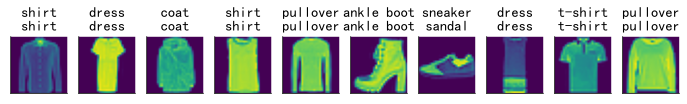

In [27]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_label(y)
pred_labels = get_fashion_mnist_label(model.predict(X))
labels = [true + "\n" + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[:10], labels[:10])

## pytorch简单实现

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision 
import torch.utils.data as Data

In [4]:
# 模型结构
class FlatternLayer(nn.Module):
    def __init__(self):
        super(FlatternLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

class PSoftmaxModel2(nn.Module):
    def __init__(self, fea_num, cate_num):
        super(PSoftmaxModel2, self).__init__()
        self.layer = nn.Sequential(
            FlatternLayer(),
            nn.Linear(fea_num, cate_num)
        )
        
    def forward(self, x): 
        # shape: (batch, 1, 28, 28)
        y = self.layer(x)
        return y
    

def evaluate_accuacy(y, y_pred):
    return (torch.argmax(y_pred, axis=1) == y).sum().item()/len(y)
    
# 定义模型
model = PSoftmaxModel2(fea_num=784, cate_num=10)
# 初始化参数
_ = init.normal_(model.layer[1].weight, 0, 0.01)
_ = init.constant_(model.layer[1].bias, 0)
# 获取数据
mnist_train, mnist_test = download_data_fashion_mnist("../data")
# loss function 
# 需要注意的是CrossEntropyLoss是softmax+交叉熵，因此不用对模型的输出加softmax
loss = nn.CrossEntropyLoss()

params = {
    "batch_size": 512,
    "epoch_num": 50,
    "data_num": len(mnist_train),
    "model": model,
    "loss": loss,
    "lr": 0.1,
    "weight_decay": 0,
    "params": None,
    "optimizer": None,
    "test_iter": Data.DataLoader(mnist_test, batch_size=len(mnist_test)),
    "evaluate": evaluate_accuacy,
}

# 优化器
optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9, 
                            weight_decay=params["weight_decay"])
params["optimizer"] = optimizer
# 加载数据
train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"])

process_bar = sqdm()
def train(model, loss, data_num, epoch_num, batch_size, lr, weight_decay=0, 
          params=None, optimizer=None, test_iter=None, evaluate=None):
    if test_iter is not None:
        test_data, test_label = iter(test_iter).next()
        
    for epoch in range(epoch_num):
        print(f"Epoch [{epoch+1}/{epoch_num}]")
        count, mean_loss, mean_score = 1., 0., 0.
        for xdata, ydata in train_iter:
            # training
            train_pred = model(xdata)
            train_loss = loss(train_pred, ydata)
            train_score = evaluate(ydata, train_pred)
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif (params is not None) and (params[0].grad is not None):
                for param in params:
                    param.grad.data.zero_()
                    
            # 反向传播
            train_loss.backward()
            # 更新梯度
            if optimizer is not None:
                optimizer.step()
            else:
                sgd(params, lr, weight_decay)
                
            # testing
            if test_iter is not None:
                test_pred = model(test_data)
                test_loss = loss(test_pred, test_label)
                test_score = evaluate(test_label, test_pred)
            
            # mean train_loss
            mean_loss = ((count-1)*mean_loss + train_loss)/count
            mean_score = ((count-1)*mean_score + train_score)/count
            count += 1
            
            process_bar.show_process(data_num, batch_size, train_loss=mean_loss.item(), 
                                     train_score=mean_score, test_loss=test_loss.item(), test_score=test_score)
        print("\n")
        
train(**params)

Epoch [1/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.6365, train_score: 0.781, test_loss: 0.5664, test_score: 0.803

Epoch [2/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4813, train_score: 0.836, test_loss: 0.5143, test_score: 0.824

Epoch [3/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4671, train_score: 0.840, test_loss: 0.5303, test_score: 0.815

Epoch [4/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4452, train_score: 0.847, test_loss: 0.4765, test_score: 0.835

Epoch [5/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4334, train_score: 0.851, test_loss: 0.4658, test_score: 0.838

Epoch [6/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4327, train_score: 0.849, test_loss: 0.4830, test_score: 0.834

Epoch [7/50]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4237, train_score: 0.854, test_loss: 0.4669, test_score: 0.838

Epoch [8/50]
60000/60000 [>>>>>>>>